We use gradient descent with backtracking.
See Nocedal, Wright: pg 37.

In [1]:
import tensorflow as tf

In [2]:
vscope = tf.get_variable_scope()
vscope.set_use_resource(True)

In [3]:
import numpy as np
import numpy.random as rnd

In [4]:
import pandas as pd
from pandas import Series, DataFrame

In [5]:
from IPython.display import display

In [6]:
from collections import OrderedDict

In [7]:
import matplotlib.pyplot as pl
%matplotlib inline

In [8]:
floatX = np.float32

In [9]:
sess = tf.InteractiveSession()

In [10]:
x = tf.Variable(
    tf.random_normal(shape = [4, 2]), 
    name = "x", dtype = floatX,
)
sess.run(x.initializer)

In [11]:
x_min = np.array([
    [0, 0],
    [3, 3],
    [3, 0],
    [0, 3],
], dtype = floatX)

In [12]:
def fun(x, name = "fun"):
    return tf.reduce_sum((x - x_min)**2, axis = -1, name = name)

In [13]:
f = fun(x)

In [14]:
df = tf.gradients(f, x)[0]

In [15]:
def plot_f(f, x, xxx = np.linspace(-5, 5, 30), yyy = None):
    if yyy is None:
        yyy = xxx
        
    N, dim = sess.run(x).shape
    assert dim == 2
    
    vals = np.empty([N, len(xxx), len(yyy)])
    for i, xx in enumerate(xxx):
        for j, yy in enumerate(yyy):
            vals[:, i, j] = sess.run(f, {x: np.ones([N, 1]) * [xx,yy]})
        
    columns = 2
    rows = int(np.ceil(N / columns))
    fig, axs = pl.subplots(rows, columns, figsize = [columns * 4, rows * 4])
    
    for val, ax in zip(vals, axs.flat):
        ax.pcolormesh(xxx, yyy, val.T)

    return axs

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020AA024B208>,
      dtype=object)

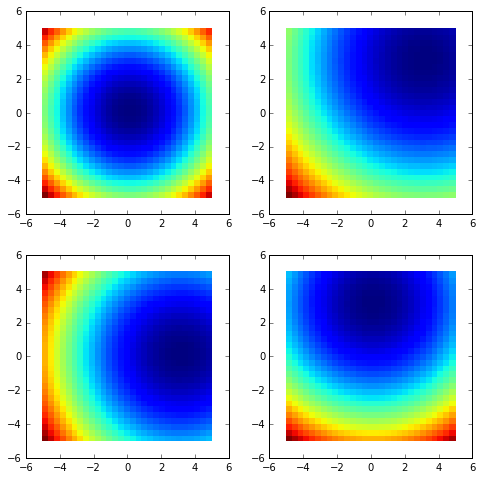

In [16]:
plot_f(f, x)

# Training
## Variables we need

In [17]:
x_c = tf.Variable([[1]], name = "x_c", dtype = floatX, validate_shape=False)
x_c.set_shape([None, None])

In [18]:
f_c = tf.Variable([1], name = "f_c", dtype = floatX, validate_shape=False)
f_c.set_shape([None])

In [19]:
df_c = tf.Variable([[1]], name = "df_c", dtype = floatX, validate_shape=False)
df_c.set_shape([None, None])

In [20]:
x_p = x

In [21]:
f_p = tf.Variable([1], name = "f_p", dtype = floatX, validate_shape=False)
f_p.set_shape([None])

In [22]:
df_p = tf.Variable([[1]], name = "df_p", dtype = floatX, validate_shape=False)
df_p.set_shape([None, None])

In [23]:
condition = tf.Variable([True], name = "condition", dtype = tf.bool, validate_shape=False)
condition.set_shape([None])

In [24]:
alpha = tf.Variable([1], name = "alpha", dtype = floatX, validate_shape=False)
alpha.set_shape([None])

In [25]:
def plot_training():
    axs = plot_f(f, x)
    for ax, xc, xp in zip(axs.flat, *sess.run([x_c, x_p])):
        ax.scatter(*xc)
        ax.scatter(*xp)
    

In [26]:
def display_vars():
    df = DataFrame(OrderedDict([
        ["x_c", list(x_c.eval())],
        ["x_p", list(x_p.eval())],
        ["alpha", alpha.eval()],
    ]))
    display(df) 

## Initialization node

In [27]:
initial_step_length = 0.5
minimal_grad_length = 1e-5
c1 = sufficient_descent_const = 0.5
rho = step_contraction_factor = 0.5

In [28]:
initialization = tf.group(
    *[
        tf.assign(var, val, name = name + "_initializer", validate_shape=False)
        for var, val, name in [
            [x_c, x, "x_c"],
            [f_c, f, "f_c"],
            [df_c, df, "df_c"],

            [f_p, f, "f_p"],
            [df_p, df, "df_p"],        
        ]
    ], 
    tf.assign(
        alpha,
        initial_step_length / tf.maximum(minimal_grad_length, tf.norm(df, axis = -1)),
        name = "alpha_initializer", 
        validate_shape = False
    ),
    tf.assign(condition, tf.cast(tf.ones_like(f), tf.bool), validate_shape=False),
    name = "initialization"
)

## Step node

$$x_p := x_c - \alpha\cdot df_c$$

In [29]:
propose_x_p = tf.assign(x_p, x_c - alpha[:, None] * df_c)

$$f_p := f(x_p)$$
$$df_p := df(x_p)$$

In [30]:
with tf.control_dependencies([propose_x_p]):
    evaluate_at_x_p = tf.group(
        tf.assign(f_p, f + 1 - 1, name = "evaluate_f_p"),
        tf.assign(df_p, df + 1 - 1, name = "evaluate_df_p"),
        name = "evaluate_at_x_p",
    )

Sufficient descent condition is:
$$f_p \leq f_c + c_1 (x_p - x_c)\cdot df_c $$
If it is satisfied then:
$$x_c := x_p; \quad f_c := f_p; \quad df_c := df_p; \quad \alpha := \alpha; \quad  $$
otherwise
$$x_c := x_c; \quad f_c := f_c; \quad df_c := df_c; \quad \alpha := \rho\cdot \alpha; \quad  $$

In [31]:
with tf.control_dependencies([evaluate_at_x_p]):
    evaluate_condition = tf.assign(
        condition,
        f_p <= f_c + c1 * tf.einsum("bi,bi->b", x_p - x_c, df_c),
        name = "evaluate_condition"
    )
  

In [32]:
with tf.control_dependencies([evaluate_condition]):
    train_step = tf.group(
        tf.assign(x_c, tf.where(condition, x_p, x_c)),
        tf.assign(f_c, tf.where(condition, f_p, f_c)),
        tf.assign(df_c, tf.where(condition, df_p, df_c)),
        tf.assign(alpha, tf.where(condition, alpha, rho * alpha)),
    )

In [33]:
def ass():
    assert (sess.run(f, {x: x_c.eval()}) == sess.run(f_c)).all()
    assert (sess.run(f, {x: x_p.eval()}) == sess.run(f_p)).all()
    
    assert (sess.run(df, {x: x_c.eval()}) == sess.run(df_c)).all()
    assert (sess.run(df, {x: x_p.eval()}) == sess.run(df_p)).all()

,x_c,x_p,alpha
0,"[1.6656475, 0.3647323]","[1.6656475, 0.3647323]",0.146618
1,"[-0.653095, -0.39856914]","[-0.653095, -0.39856914]",0.050105
2,"[1.1729342, -1.5203153]","[1.1729342, -1.5203153]",0.105180
3,"[-0.38550696, -0.2135624]","[-0.38550696, -0.2135624]",0.077241


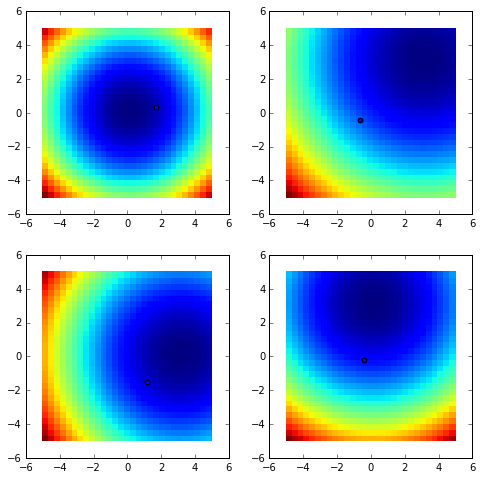

In [34]:
sess.run(x.initializer)
sess.run(initialization)
ass()
plot_training()
display_vars()

In [36]:
sess.run(train_step)
ass()
plot_training()
display_vars()

AssertionError: 

In [37]:
sess.run(x.initializer)
sess.run(initialization)
ass()
sess.run(evaluate_at_x_p)
ass()


AssertionError: 

In [38]:
sess.run([x, x_c])

[array([[-0.00924554, -0.06156942],
        [-1.3705525 , -0.26961714],
        [-1.1534494 , -1.6467015 ],
        [-0.1637545 ,  1.0304296 ]], dtype=float32),
 array([[-0.0834953 , -0.5560257 ],
        [-1.770917  , -0.5691305 ],
        [-1.618252  , -1.83098   ],
        [-0.20518266,  0.5321489 ]], dtype=float32)]

In [39]:
sess.run([f, f_p, f_c])

[array([3.8762738e-03, 2.9792126e+01, 1.9962769e+01, 3.9060230e+00],
       dtype=float32),
 array([ 0.316136 , 35.50034  , 24.680737 ,  6.1323895], dtype=float32),
 array([ 0.31613603, 35.50034   , 24.680737  ,  6.1323895 ], dtype=float32)]

In [28]:
s1 = tf.assign(x_p, x_c - alpha[:, None] * df_c)

In [29]:
s2 = tf.assign(x, x_p)

In [30]:
s3 = tf.group(
    tf.assign(f_p, f, name = "evaluate_f_p"),
    tf.assign(df_p, df, name = "evaluate_df_p"),
    name = "evaluate_at_x_p",
)

In [31]:
s4 = tf.assign(
    condition, 
    f_p <= f_c + c1 * tf.einsum("bi,bi->b", x_p - x_c, df_c),
    name = "condition_evaluation"
)
s5 = tf.group(
    tf.assign(x_c, tf.where(condition, x_p, x_c)),
    tf.assign(f_c, tf.where(condition, f_p, f_c)),
    tf.assign(df_c, tf.where(condition, df_p, df_c)),
    tf.assign(alpha, tf.where(condition, alpha, rho * alpha)),
)

In [ ]:
sess.run(x.initializer)
sess.run(initialization)
plot_training()
display_vars()
assert (sess.run(f, {x: x_c.eval()}) == sess.run(f_c)).all()

,x_c,x_p,alpha
0,"[-0.001545786, 0.0039919917]","[-0.00092319946, 0.002384162]",0.201382
1,"[1.8525785, 1.8386115]","[1.9652777, 1.9526825]",0.049110
2,"[2.551509, 0.32119203]","[2.6190372, 0.27283096]",0.075284
3,"[-0.01296819, 2.9859216]","[-0.0087112505, 2.990543]",0.164130


[ True  True  True  True]


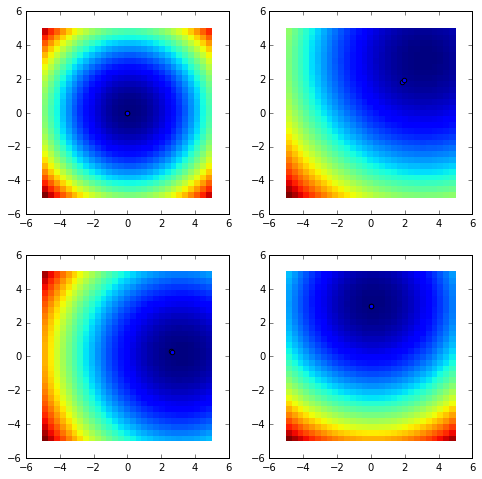

In [45]:
sess.run(s1)
sess.run(s2)
sess.run(s3)
ass()

plot_training()
display_vars()

sess.run(s4)
ass()
print(condition.eval())

sess.run(s5)
ass()


In [46]:
steps = [s1, s2, s3, s4, s5]

In [56]:
cs1 = tf.identity(s1, "cs1")

In [58]:
with tf.control_dependencies([cs1]):
    cs2 = tf.identity(s2, "cs2")

In [60]:
with tf.control_dependencies([cs2]):
    cs3 = tf.group(s3, name = "cs3")

In [61]:
with tf.control_dependencies([cs3]):
    cs4 = tf.identity(s4, name = "cs4")

In [62]:
with tf.control_dependencies([cs4]):
    cs5 = tf.group(s5, name = "cs5")

In [67]:
ass()
sess.run(cs3)
ass()

plot_training()
display_vars()

AssertionError: 

In [71]:
cum_steps = [tf.Print(s1, [], "cs1")]
for s in steps[1:]:
    with tf.control_dependencies([cum_steps[-1]]):
        cs = tf.group(
            s,
            tf.Print(1,[], message = "cs{}".format(len(cum_steps) + 2))
        )
        cum_steps.append(cs)
    

In [74]:
sess.run(cs1)

array([[ 0.07502855, -0.31464154],
       [-0.05093732, -0.7964755 ],
       [ 1.0402911 , -0.15530856],
       [ 2.1225262 ,  0.7704322 ]], dtype=float32)

In [53]:
cum_steps = [tf.Print(s1, [], message = "cs1")]
for s in steps[1:]:
    with tf.control_dependencies([cum_steps[-1]]):
        cs = tf.Print(s, [], message = "cs{}".format(len(cum_steps) + 2))
        cum_steps.append(cs)
    

TypeError: Can't convert Operation 'evaluate_at_x_p' to Tensor (target dtype=None, name='input', as_ref=False)

In [52]:
s

(<tf.Operation 'evaluate_at_x_p' type=NoOp>,)